<a href="https://colab.research.google.com/github/Ashish-Tripathy/ComputerVision/blob/master/ENAS_Discovered_Network_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import *
import tensorflow as tf

# Loading the Cifar Data

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

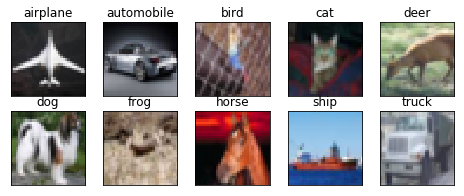

In [9]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Defining Functions for Model Stats

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# Data Preprocessing

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Implementing ENAS discovered network in Keras

ENAS trains deep learning to discover network for a particular task. The below network was discovered by ENAS when trained on CIFAR10 data to find the archiecture which best reduced the error % on this data.

![](https://2.bp.blogspot.com/-HQo2Kx39Q6A/WsqZQn5pJHI/AAAAAAAAVhY/FBkgOeS06vQNvZN2KI2hhGZmfS1cNPg8wCLcBGAs/s1600/enasdiscoverednetwork.png)

Lower number of filters in the implementation below has been decided to reduce the run time for each epochs. ENAS paper recommends using the same architecture with higher number of filters to reduce error percentage. They recommend the the network's highest layer to have 512 filters.

In [0]:
#space_to_depth helps in concatenating different sized layers
def space_to_depth_x(x):
    return tf.space_to_depth(x, block_size=2)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=4)


In [35]:
from keras.models import Model
from keras.layers import Input,Conv2D, BatchNormalization,Activation, Flatten,SeparableConv2D
from keras.regularizers import l2
from keras.layers import Concatenate, concatenate, Lambda

input = Input(shape=(32, 32, 3,))

#defining convolution block
def conv_block(inputs, filters, kernel_size = (3,3) ,padding = 'valid', dilation_rate = 1):
  conv = Conv2D(filters = filters, kernel_size = kernel_size, padding=padding, dilation_rate=dilation_rate, use_bias=False)(inputs)     
  conv = Dropout(0.2)(conv)
  conv = BatchNormalization()(conv) # BN before ReLu
  conv = Activation('relu')(conv)
  return conv


#defining spatially separable convolution
def separable_conv(inputs, filters, kernel, padding = 'valid', ):
  conv = Conv2D(filters = filters, kernel_size = (kernel,1), padding = padding,use_bias=False)(inputs)
  conv = Conv2D(filters = filters*2, kernel_size = (1,kernel), padding = padding,use_bias=False)(conv)
  conv = Dropout(0.2)(conv)
  conv = BatchNormalization()(conv) # BN before ReLu
  conv = Activation('relu')(conv)
  return conv

#defining transition block
def maxpool(inputs):
  return MaxPooling2D()(inputs)



#Building the architecture
x1   =     separable_conv(input,kernel=5,filters = 8, padding = 'same') #op = 32x32x16
x2   =     conv_block(x1,kernel_size = (5,5), filters = 8, padding = 'same') #op = 32x32x32
x3   =     conv_block(x2,kernel_size = (5,5), filters = 16, padding = 'same') #op = 32x32x32

##skip connections for x4
x1s1 =     concatenate([x1,x3]) #op = 32x32x64
x4   =     separable_conv(x1s1,kernel=5,filters = 16, padding = 'same') 

##skip connections for m1
x1s2 =     concatenate([x1,x4])
m1   =     maxpool(x1s2)
x5   =     separable_conv(m1,kernel=3,filters = 16, padding = 'same')
x1x4s1 =   concatenate([Lambda(space_to_depth_x)(x1),Lambda(space_to_depth_x)(x4),x5])
x6   =     conv_block(x1x4s1,kernel_size = (5,5), filters = 16, padding = 'same')

##skip connections for x7
x3x4x6s1 = concatenate([Lambda(space_to_depth_x)(x3),Lambda(space_to_depth_x)(x4),x5,x6])
x7   =     separable_conv(x1x4s1,kernel=3,filters = 16, padding = 'same')

##skip connections for x8
x1x3x4x5x6s1 = concatenate([Lambda(space_to_depth_x)(x1),Lambda(space_to_depth_x)(x3),Lambda(space_to_depth_x)(x4),x5,x6,x7])
x8   =     separable_conv(x1x3x4x5x6s1,kernel=5,filters = 16, padding = 'same')

##skip connection for m2
x1x4x5x7s1 = concatenate([Lambda(space_to_depth_x)(x1),Lambda(space_to_depth_x)(x4),x5,x7,x8])
m2   =     maxpool(x1x4x5x7s1)

##skip connection for x9
x6s1 =     concatenate([Lambda(space_to_depth_x)(x6),m2]) 
x9   =     conv_block(x6s1,kernel_size = (5,5), filters = 16, padding = 'same')

##skip connection for x10
x2x4x7 =   concatenate([Lambda(space_to_depth_x2)(x2),Lambda(space_to_depth_x2)(x4),Lambda(space_to_depth_x)(x7),x9])
x10    =     separable_conv(x2x4x7,kernel=5,filters = 16, padding = 'same') 

##skip connection for x11
x2x3x5x9s1 = concatenate([Lambda(space_to_depth_x2)(x2),Lambda(space_to_depth_x2)(x3),Lambda(space_to_depth_x)(x5),x9,x10])
x11  =     conv_block(x2x3x5x9s1,kernel_size = (3,3), filters = 32, padding = 'same')

##skip connection for x12
x1x3x4x5x7x10s1 = concatenate([Lambda(space_to_depth_x2)(x1),Lambda(space_to_depth_x2)(x3),Lambda(space_to_depth_x2)(x4),
                               Lambda(space_to_depth_x)(x5),Lambda(space_to_depth_x)(x7),x10, x11])
x12  =     separable_conv(x1x3x4x5x7x10s1,kernel=5,filters = 16, padding = 'same') 

##skip connection for softmax
x4x7x10s1 = concatenate([Lambda(space_to_depth_x2)(x4),Lambda(space_to_depth_x)(x7),x10, x12])


last1x1      =  Conv2D(filters = 10, kernel_size = (1,1), padding = 'valid', use_bias = False)(x4x7x10s1)
last1x1      =  Activation('relu')(last1x1)
last_layer   =  Conv2D(filters = 10, kernel_size = (8,8), padding = 'valid', use_bias = False)(last1x1) 
flatten      =  Flatten()(last_layer)
output       =  Activation('softmax')(flatten)

#creating the model
model = Model(inputs=[input], outputs=[output])

#model summary
model.summary()

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 32, 32, 8)    120         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_254 (Conv2D)             (None, 32, 32, 16)   640         conv2d_253[0][0]                 
__________________________________________________________________________________________________
dropout_154 (Dropout)           (None, 32, 32, 16)   0           conv2d_254[0][0]                 
__________________________________________________________________________________________________
batch_norm

## Training the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 40s 104ms/step - loss: 1.6232 - acc: 0.4096 - val_loss: 1.6603 - val_acc: 0.4304
Epoch 2/100
390/390 [==============================] - 29s 75ms/step - loss: 1.2125 - acc: 0.5623 - val_loss: 1.3393 - val_acc: 0.5439
Epoch 3/100
390/390 [==============================] - 28s 73ms/step - loss: 1.0250 - acc: 0.6339 - val_loss: 1.1717 - val_acc: 0.6119
Epoch 4/100
390/390 [==============================] - 28s 73ms/step - loss: 0.9146 - acc: 0.6762 - val_loss: 1.0958 - val_acc: 0.6340
Epoch 5/100
390/390 [==============================] - 29s 74ms/step - loss: 0.8325 - acc: 0.7070 - val_loss: 1.0150 - val_acc: 0.6680
Epoch 6/100
390/390 [==============================] - 29s 73ms/step - loss: 0.7794 - acc: 0.7257 - val_loss: 1.0382 - val_acc: 0.6710
Epoch 7/100
390/390 [==============================] - 28s 73ms/step - loss: 0.7262 - acc: 0.7415 - val_loss: 1.0349 - val_acc: 0.6694
Epoch 8/100
390/390 [==============================] -

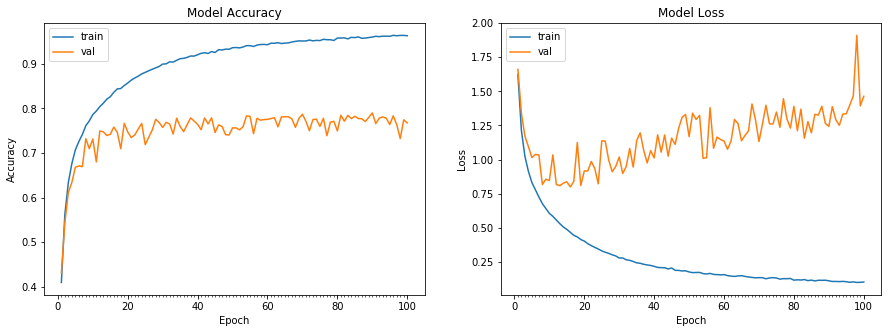

Accuracy on test data is: 76.75


In [36]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1 )


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
